#Computación evolutiva para encontrar localizaciones optimas de una cadena de supermercados

##Librerías utilizadas

In [ ]:
import numpy as np
from random import uniform, randrange
from copy import deepcopy
import random
import math
import pandas as pd
import matplotlib.pyplot as plt

##Hiperparámetros

In [ ]:
# Hiperparámetros para el algoritmo genético
MAX_POP_SIZE = 25         # Tamaño máximo de la población
CHROMOSOME_SIZE = 60       # Tamaño del cromosoma (número de ubicaciones candidatas)
GENERATIONS = 100          # Número de generaciones
PMUT = 0.1                 # Tasa de mutación
CROSSOVER = "onepoint"     # Operador de cruzamiento: "onepoint" o "uniform"
MUTATION = "flip"          # Operador de mutación: "flip", "inversion" o "multiflip"
SELECTION = "tournament"   # Método de selección de padres para cruzamiento: "roulette" o "tournament"
MAX_SUPERMARKETS = 10      # Número máximo de supermercados

##Objeto Location

In [ ]:
class Location(object):
    def __init__(self, coordinates, population):
        self.coordinates = coordinates  # Coordenadas de la ubicación
        self.population = population    # Población estimada alrededor de la ubicación

##Estructura de un individuo en el AG con sus operadores genéticos

In [ ]:
class Individual:

  def __init__(self, chromosome):  # el constructor recibe un cromosoma
    self.chromosome = chromosome[:]
    self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

  def crossover_onepoint(self, other):
    "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
    min_len = min(len(self.chromosome), len(other.chromosome))
    c = randrange(min_len)

    # Asegura que ambos cromosomas tengan la misma longitud
    padded_self_chromosome = np.pad(self.chromosome, (0, len(other.chromosome) - len(self.chromosome)))
    padded_other_chromosome = np.pad(other.chromosome, (0, len(self.chromosome) - len(other.chromosome)))

    # Utiliza np.concatenate para asegurar la correcta concatenación
    ind1 = Individual(np.concatenate((padded_self_chromosome[:c], padded_other_chromosome[c:])))
    ind2 = Individual(np.concatenate((padded_other_chromosome[:c], padded_self_chromosome[c:])))
    return [ind1, ind2]

  def crossover_uniform(self, other):
    chromosome1 = []
    chromosome2 = []
    "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
    for i in range(len(self.chromosome)):
        if uniform(0, 1) < 0.5:
            chromosome1.append(self.chromosome[i])
            chromosome2.append(other.chromosome[i])
        else:
            chromosome1.append(other.chromosome[i])
            chromosome2.append(self.chromosome[i])
    ind1 = Individual(chromosome1)
    ind2 = Individual(chromosome2)
    return [ind1, ind2]

  def mutation_flip(self):
    "Cambia aleatoriamente el alelo de un gen."
    new_chromosome = deepcopy(self.chromosome)
    mutGene = randrange(0, len(new_chromosome))   # escoge un gen para mutar
    if new_chromosome[mutGene] == 0:
        new_chromosome[mutGene] = 1
    else:
        new_chromosome[mutGene] = 0
    return Individual(new_chromosome)

  def dominates(self, other):
    """
    Determina si este individuo domina a otro.
    Un individuo domina a otro si es mejor en al menos un objetivo y no peor en los demás.
    """
    better_in_at_least_one = False
    for self_fit, other_fit in zip(self.fitness, other.fitness):
        if self_fit < other_fit:  # Aquí se asume que un fitness menor es mejor; ajusta según sea necesario
            return False
        elif self_fit > other_fit:
            better_in_at_least_one = True

    return better_in_at_least_one

##Funciones necesarias

In [ ]:
def get_fitness(chromosome, locations, max_supermarkets):
    # Este ejemplo asume que quieres maximizar la población total y minimizar la distancia total
    # fitness[0] = población total, fitness[1] = distancia total negativa (ya que queremos minimizarla)
    fitness = np.zeros(2)
    selected_locations = [loc for loc, selected in zip(locations, chromosome) if selected]

    if len(selected_locations) <= max_supermarkets:
        fitness[0] = sum_population(selected_locations)
        fitness[1] = -sum_distances(selected_locations)

    return fitness

def sum_distances(selected_locations):
    """Calcula la suma de distancias entre todas las localizaciones seleccionadas."""
    distance_sum = 0
    for i in range(len(selected_locations) - 1):
        for j in range(i + 1, len(selected_locations)):
            distance_sum += calculate_distance(selected_locations[i], selected_locations[j])
    return distance_sum

def haversine(coord1, coord2):
    # Radio de la Tierra en km
    R = 6371.0

    lat1, lon1 = coord1
    lat2, lon2 = coord2

    # Convertir coordenadas de grados a radianes
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    # Aplicar la fórmula de Haversine
    a = math.sin(delta_phi / 2.0)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c  # Resultado en kilómetros

    return distance

def calculate_distance(loc1, loc2):
    # Implementa la función de distancia usando la fórmula de Haversine
    return haversine((loc1.coordinates[0], loc1.coordinates[1]), (loc2.coordinates[0], loc2.coordinates[1]))

def sum_population(selected_locations):
    """Calcula la suma de población de las localizaciones seleccionadas."""
    return sum([loc.population for loc in selected_locations])

def init_population(pop_size, chromosome_size):
    # Inicializa una población de pop_size individuos, cada cromosoma de individuo de tamaño chromosome_size.
    population = []
    for i in range(pop_size):
        new_chromosome = np.zeros(chromosome_size)
        ones = randrange(1, chromosome_size)  # Al menos una ubicación debe ser seleccionada
        new_chromosome[:ones] = 1
        np.random.shuffle(new_chromosome)

        population.append(Individual(new_chromosome))
    return population

def evaluate_population(population, locations, max_supermarkets):
    """Evalúa una población de individuos con la función get_fitness"""
    pop_size = len(population)

    for i in range(pop_size):
        if population[i].fitness == -1:    # evalúa solo si el individuo no está evaluado
            population[i].fitness = get_fitness(population[i].chromosome, locations, max_supermarkets)

def select_parents_roulette(population):
    """Selecciona padres mediante el método de la ruleta.

    Args:
        population (list): Lista de objetos Individual.

    Returns:
        tuple: Dos objetos Individual seleccionados como padres.
    """
    fitness_sum = sum(ind.fitness[1] for ind in population)  # Usar fitness[1] que es la suma de población
    pick1 = uniform(0, fitness_sum)
    pick2 = uniform(0, fitness_sum)

    current_sum = 0
    parent1, parent2 = None, None

    for ind in population:
        current_sum += ind.fitness[1]  # Usar fitness[1] que es la suma de población
        if current_sum > pick1 and parent1 is None:
            parent1 = ind

        if current_sum > pick2 and parent2 is None:
            parent2 = ind

        if parent1 is not None and parent2 is not None:
            break

        if parent1 is None or parent2 is None:
        # Puedes elegir padres al azar o implementar otra lógica
           parent1 = random.choice(population)
           parent2 = random.choice(population)

    return parent1, parent2

def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)

    iParent1=np.argmax(list_indiv)

    # Escoje el segundo padre, desconsiderando el primer padre
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)

    return (population[x1[iParent1]],population[x2[iParent2]])

def select_survivors_ranking(population, offspring_population, pop_size):
    """Selecciona sobrevivientes utilizando el método de ranking"""
    all_individuals = population + offspring_population
    all_individuals = sorted(all_individuals, key=lambda x: x.fitness[0], reverse=True)
    return all_individuals[:pop_size]

def fast_non_dominated_sort(population):
    fronts = [[]]
    for p in population:
        p.dominated_solutions = set()
        p.domination_count = 0
        for q in population:
            if p.dominates(q):
                p.dominated_solutions.add(q)
            elif q.dominates(p):
                p.domination_count += 1
        if p.domination_count == 0:
            p.rank = 0
            fronts[0].append(p)

    i = 0
    while len(fronts[i]) > 0:
        next_front = []
        for p in fronts[i]:
            for q in p.dominated_solutions:
                q.domination_count -= 1
                if q.domination_count == 0:
                    q.rank = i + 1
                    next_front.append(q)
        i += 1
        fronts.append(next_front)

    return fronts[:-1]

def calculate_crowding_distance(front):
    if not front:
        return

    number_of_objectives = len(front[0].fitness)
    for individual in front:
        individual.crowding_distance = 0

    for m in range(number_of_objectives):
        front.sort(key=lambda x: x.fitness[m])
        front[0].crowding_distance = front[-1].crowding_distance = float('inf')

        for i in range(1, len(front) - 1):
            if front[-1].fitness[m] - front[0].fitness[m] == 0:
                continue

            front[i].crowding_distance += (front[i + 1].fitness[m] - front[i - 1].fitness[m]) / (front[-1].fitness[m] - front[0].fitness[m])


def select_next_generation(population, fronts, pop_size):
    # Implementación de la función para seleccionar la siguiente generación
    new_population = []
    for front in fronts:
        calculate_crowding_distance(front)
        front.sort(key=lambda x: (x.rank, -x.crowding_distance))
        new_population.extend(front)

        if len(new_population) >= pop_size:
            break

    return new_population[:pop_size]

def update_pareto_front(pareto_front, population):
    # Combinar el frente de Pareto actual con la nueva población
    combined = pareto_front + population

    # Filtrar para obtener el nuevo frente de Pareto (soluciones no dominadas)
    new_pareto_front = []
    for individual in combined:
        if not any(other.dominates(individual) for other in combined if other is not individual):
            new_pareto_front.append(individual)

    return new_pareto_front



def genetic_algorithm(poblacion_inicial, locations, max_supermarkets, ngen=100, pmut=0.1,
                      crossover="onepoint", mutation="flip",
                      selection_parents_method="roulette",
                      selection_survivors_method="nsga2"):
    """Algoritmo Genético para el problema de ubicación de supermercados
        locations:  lista de objetos de clase Location
        max_supermarkets: número máximo de supermercados a ubicar
        ngen:       máximo número de generaciones
        pmut:       tasa de mutación
        crossover:  operador de cruzamiento
        mutation:   operador de mutación
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes
    """

    population = deepcopy(poblacion_inicial)  # copia la población inicial en una nueva variable para no alterar la inicial

    popsize = len(population)
    evaluate_population(population, locations, max_supermarkets)  # evalua la población inicial
    ibest = max(range(len(population)), key=lambda i: population[i].fitness[0])  # mejor individuo
    bestfitness = [population[ibest].fitness[0]]  # fitness del mejor individuo
    print("Población inicial, mejor fitness = {}".format(population[ibest].fitness[0]))

    pareto_front = []

    for g in range(ngen):   # Por cada generación

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el método de la ruleta
        mating_pool = []
        for i in range(int(popsize/2)):
            if selection_parents_method == "roulette":
                mating_pool.append(select_parents_roulette(population))
            elif selection_parents_method == "tournament":
                mating_pool.append(select_parents_tournament(population, 3))
            else:
                raise NotImplementedError

        ## Crea la población descendencia cruzando las parejas del mating pool
        offspring_population = []
        for i in range(len(mating_pool)):
            if crossover == "onepoint":
                offspring_population.extend(mating_pool[i][0].crossover_onepoint(mating_pool[i][1]))  # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend(mating_pool[i][0].crossover_uniform(mating_pool[i][1]))  # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutación con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if uniform(0, 1) < pmut:
                if mutation == "flip":
                    offspring_population[i] = offspring_population[i].mutation_flip()  # cambia el alelo de un gen
                else:
                    raise NotImplementedError

        for i in range(len(mating_pool)):
            parent1, parent2 = mating_pool[i]
        if parent1 is None or parent2 is None:
            continue  # Saltar esta iteración si alguno de los padres es None

        if crossover == "onepoint":
            offspring_population.extend(parent1.crossover_onepoint(parent2))
        elif crossover == "uniform":
            offspring_population.extend(parent1.crossover_uniform(parent2))
        else:
            raise NotImplementedError

         ## Evalua la población descendiente creada
        evaluate_population(offspring_population, locations, max_supermarkets)   # evalua la población descendencia

        ## Unir la población actual y la descendiente
        combined_population = population + offspring_population

        ## NSGA-II: Ordenamiento no dominado y selección basada en distancia de multitud
        if selection_survivors_method == "nsga2":
            fronts = fast_non_dominated_sort(combined_population)
            population = select_next_generation(combined_population, fronts, popsize)
        elif selection_survivors_method == "ranking":
          fronts = fast_non_dominated_sort(combined_population)
          population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError

        ## Actualizar el frente de Pareto
        pareto_front = update_pareto_front(pareto_front, population)

        ## Almacena la historia del fitness del mejor individuo
        ibest = max(range(len(population)), key=lambda i: population[i].fitness[0])
        bestfitness.append(population[ibest].fitness[0])

    print("Mejor individuo en la última generación = {} (fitness = {})".format(population[ibest].chromosome, population[ibest].fitness[0]))
    return population[ibest], bestfitness, pareto_front  # Devuelve el mejor individuo, el registro de fitness y el frente de Pareto

##Evaluar algoritmo monoobjetivo

In [ ]:
# Cargar datos desde el archivo Excel
excel_file_path = '/content/Candidatos_supermercados.xlsx'  # Asegúrate de tener la ruta correcta
df = pd.read_excel(excel_file_path)
locations_data = df.to_dict(orient='records')

# Crear objetos Location
locations = [Location(coordinates=(data['Latitud'], data['Longitud']), population=data['Poblacion500m']) for data in locations_data]
df.head(5)

,ID,Descripcion,Latitud,Longitud,Poblacion500m
0,Punto 1,Esq. Benavides con Nicolas Dueñas,-12.04861,-77.06496,16500
1,Ponto 2,Sta Bernardita con Republica de Venezuela,-12.05956,-77.07583,18000
2,Ponto 3,Santa Susana con Santa Gertrudis,-12.06524,-77.07334,17000
3,Ponto 4,Belizario Sosa Pelaez,-12.05998,-77.06300,15000
4,Ponto 5,Esq. Aurelio Garcia y Miranono Arredondo,-12.05541,-77.07497,17100


In [ ]:
# Inicializar la población
poblacion_inicial = init_population(MAX_POP_SIZE, CHROMOSOME_SIZE)

In [ ]:
# Ejecutar el algoritmo genético multiobjetivo
best_ind, best_fitness, pareto_front = genetic_algorithm(poblacion_inicial, locations, MAX_SUPERMARKETS,
                                                         ngen=GENERATIONS, pmut=PMUT,
                                                         crossover=CROSSOVER, mutation=MUTATION,
                                                         selection_parents_method=SELECTION,
                                                         selection_survivors_method="ranking")


Población inicial, mejor fitness = 147700.0
Mejor individuo en la última generación = [1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] (fitness = 158450.0)


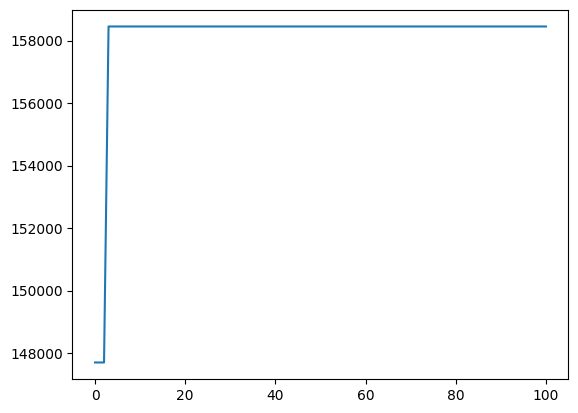

In [ ]:
plt.plot(best_fitness)
plt.show()

In [ ]:
fitness_mono = get_fitness(best_ind.chromosome, locations, MAX_SUPERMARKETS)
print(fitness_mono)

[158450.           -325.35196302]


##Algoritmos Multiobjetivo

In [ ]:
def build_offspring_population(population, crossover, mutation, pmut):
    """ Construye una poblacion hija con los operadores de cruzamiento y mutacion pasados
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        pmut:       taza de mutacion
    """
    pop_size = len(population)

    ## Selecciona parejas de individuos (mating_pool) para cruzamiento

    mating_pool = []
    for i in range(int(pop_size/2)):
        # escoje dos individuos diferentes aleatoriamente de la poblacion
        permut = np.random.permutation( pop_size )
        mating_pool.append( (population[permut[0]], population[permut[1]] ) )

    ## Crea la poblacion descendencia cruzando las parejas del mating pool
    offspring_population = []
    for i in range(len(mating_pool)):
        if crossover == "onepoint":
            offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
        elif crossover == "uniform":
            offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
        else:
            raise NotImplementedError

    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
        if uniform(0, 1) < pmut:
            if mutation == "flip":
                offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
            else:
                raise NotImplementedError

    return offspring_population

def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """

    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normalisa los fitnesses entre 0 y 1 (ptp es max - min)
    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

def select_by_crowding(population, num_individuals):
    """
    Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
    y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
    """
    population = deepcopy(population)
    pop_size = len(population)

    num_objectives = len(population[0].fitness)

    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = population[i].fitness

    # obtiene las  distancias  crowding
    crowding_distances = get_crowding_distances(fitnesses)

    population_selected = []   # poblacion escogida

    for i in range(num_individuals):  # por cada individuo a seleccionar

        # escoje dos individuos aleatoriamente de la poblacion no escogida aun
        permut = np.random.permutation( len(population) )
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

            # traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind1_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)

        else:  # Si ind2_id es el mejor

            # traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind2_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return (population_selected)

def get_paretofront_population(population):
    """
    Obtiene de population la poblacion de individups de la frontera de Pareto,
    """
    population = deepcopy(population)
    pop_size = len(population)

    # todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)

    for i in range(pop_size): # Compara cada individuo contra todos los demas
        for j in range(pop_size):
            # Chequea si individuo 'i' es dominado por individuo 'j'
            #if all(population[j].fitness >= population[i].fitness) and any(population[j].fitness > population[i].fitness):
            #if str(all(population[j].fitness >= population[i].fitness)) and str(any(population[j].fitness > population[i].fitness)):
            if all(np.asarray(population[j].fitness) >= np.asarray(population[i].fitness)) and any(np.asarray(population[j].fitness) > np.asarray(population[i].fitness)):
                # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                pareto_front[i] = 0
                break   # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # construye la lista de individuos de la frontera de Pareto
        if pareto_front[i] == 1: paretofront_population.append(population[i])

    return paretofront_population

def build_next_population(population, min_pop_size, max_pop_size):
    """
    Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta
    tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
    crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
    """
    population = deepcopy(population)
    pareto_front = []
    next_population = []

    while len(next_population) < min_pop_size:   # mientras la poblacion no tenga el tamaño minimo
        # obtiene la poblacion frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)

        # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if  combined_population_size > max_pop_size:
            paretofront_population = select_by_crowding( paretofront_population, max_pop_size-len(next_population) )

        # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
        next_population.extend( paretofront_population )

        # remueve de population los individuos que fueron agregados a next_population
        for i in range( len(paretofront_population) ):
            for j in range( len(population) ):
                if all( np.asarray(paretofront_population[i].chromosome) == np.asarray(population[j].chromosome) ):
                    del(population[j])
                    break

    return next_population

##Evaluar algoritmo Multiobjetivo

In [ ]:
## CODIGO PRINCIPAL DEL  ALGORITMO GENETICO  NSGA-II

P = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la poblacion inicial

#  evalua la poblacion inicial
evaluate_population(P, locations, MAX_SUPERMARKETS)

## Ejecuta los ciclos evolutivos
for g in range(GENERATIONS):   # Por cada generacion

    if g %10 == 0:
        print ('Generacion {} (de {}) '.format(g, GENERATIONS))

    ## genera y evalua la poblacion hija
    Q = build_offspring_population(P, CROSSOVER, MUTATION, PMUT)
    evaluate_population(Q, locations, MAX_SUPERMARKETS)

    ## une la poblacion padre y la poblacion hija
    P.extend(Q)

    ## Construye la poblacion de la siguiente generacion
    P = build_next_population(P, 10, MAX_POP_SIZE)

# Obtiene la poblacion de la frontera de pareto final
pareto_front_population = get_paretofront_population(P)

Generacion 0 (de 100) 
Generacion 10 (de 100) 
Generacion 20 (de 100) 
Generacion 30 (de 100) 
Generacion 40 (de 100) 
Generacion 50 (de 100) 
Generacion 60 (de 100) 
Generacion 70 (de 100) 
Generacion 80 (de 100) 
Generacion 90 (de 100) 


In [ ]:
import matplotlib.pyplot as plt

def plot_pareto_front(pareto_front):
    # Asumiendo que pareto_front es una lista de individuos
    # y cada individuo tiene un atributo 'fitness' que es una lista o tupla de valores de fitness
    objective_1 = [ind.fitness[0] for ind in pareto_front]  # Por ejemplo, el primer objetivo
    objective_2 = [ind.fitness[1] for ind in pareto_front]  # Por ejemplo, el segundo objetivo

    plt.scatter(objective_1, objective_2)
    plt.xlabel('Objetivo 1')
    plt.ylabel('Objetivo 2')
    plt.title('Frontera de Pareto')
    plt.show()

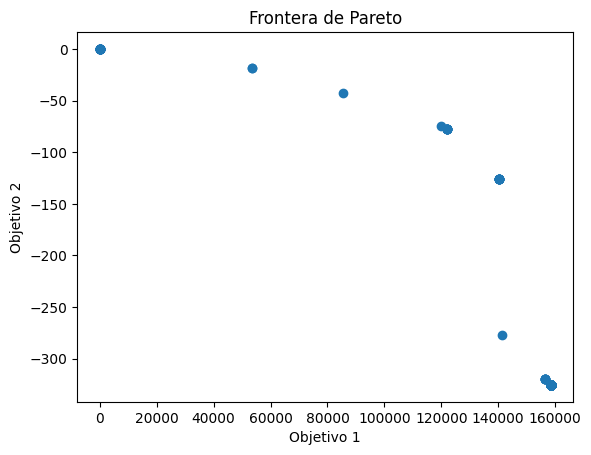

In [ ]:
# Visualizar la frontera de Pareto
plot_pareto_front(pareto_front)

#Comparación AG Monoobjetivo y Multiobjetivo

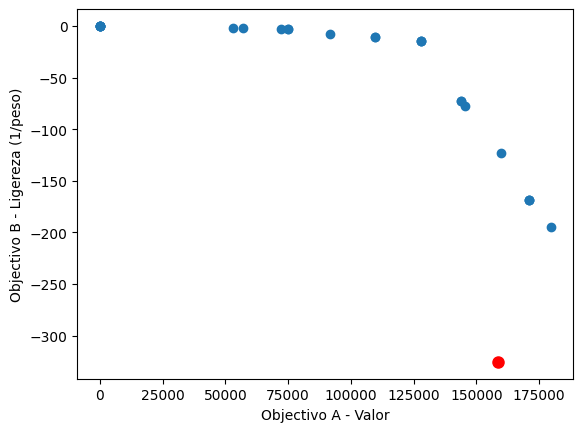

In [ ]:
## Plotea los individuos de la frontera de Pareto final
pop_size = len(pareto_front_population)
num_objectives = len(pareto_front_population[0].fitness)

# extrae los fitness de la poblacion en la matriz fitnesses
fitnesses = np.zeros([pop_size, num_objectives])
for i in range(pop_size): fitnesses[i,:] = pareto_front_population[i].fitness

x = fitnesses[:, 0]
y = fitnesses[:, 1]

plt.xlabel('Objectivo A - Valor')
plt.ylabel('Objectivo B - Ligereza (1/peso)')
plt.scatter(x,y)

# Fitness mono-objetivo
plt.plot(fitness_mono[0], fitness_mono[1], marker="o", markersize=8, markeredgecolor="red", markerfacecolor="red")

plt.show()